In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

import matplotlib.pyplot as plt

from models.densenet import DenseNet3
import util.svhn_loader as svhn

In [2]:
transform_cifar = transforms.Compose([
  transforms.Resize(32),
  transforms.CenterCrop(32),
  transforms.ToTensor(),
  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

datasets = {
  'CIFAR-10': torchvision.datasets.CIFAR10(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar),
  'CIFAR-100': torchvision.datasets.CIFAR100(root='./datasets/id_datasets/', train=False, download=True, transform=transform_cifar), 
  'SVHN': svhn.SVHN('datasets/ood_datasets/svhn/', split='test', transform=transform_cifar, download=False),
  'dtd': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/dtd/images", transform=transform_cifar),
  'places365': torchvision.datasets.ImageFolder(root="datasets/ood_datasets/places365/", transform=transform_cifar),
  'celebA': torchvision.datasets.CelebA(root='datasets/ood_datasets/', split='test', download=True, transform=transform_cifar),
  'iSUN': torchvision.datasets.ImageFolder("./datasets/ood_datasets/iSUN", transform=transform_cifar),
  'LSUN': torchvision.datasets.ImageFolder("./datasets/ood_datasets/LSUN", transform=transform_cifar),
  'LSUN_resize': torchvision.datasets.ImageFolder("./datasets/ood_datasets/LSUN_resize", transform=transform_cifar),
}

dataloaders = {
  k: torch.utils.data.DataLoader(v, batch_size=128, shuffle=False) for k,v in datasets.items()
}

ood_dls = ['SVHN', 'LSUN', 'LSUN_resize', 'iSUN', 'dtd', 'places365']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import sys
sys.path.append('./code/')

from stats import Stats

device = 'cuda:1'

In [4]:
model = DenseNet3(100, 10, 12, reduction=0.5, bottleneck=True, dropRate=0.0, normalizer=None, p=None, info=None)
checkpoint = torch.load("./checkpoints/CIFAR-10/densenet/checkpoint_100.pth.tar", map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval();

In [5]:
# _, eval_nodes = get_graph_node_names(model)
# print(eval_nodes)

In [6]:
return_nodes = {
  'x': 'input',
  'conv1': 'conv',
  'trans1.avg_pool2d': 'block1',
  'trans2.avg_pool2d': 'block2',
  'avg_pool2d': 'block3',
  # 'block1.layer.15.cat': 'block1',
  # 'block2.layer.15.cat': 'block2',
  # 'block3.layer.15.cat': 'block3',
  'view': 'feature',
  'fc': 'logit',
}

s = Stats(model, return_nodes, device)
s.run(dataloaders['CIFAR-10'])

  0%|          | 0/79 [00:00<?, ?it/s]

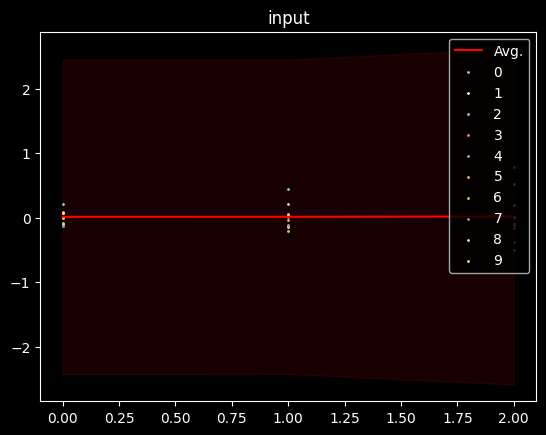

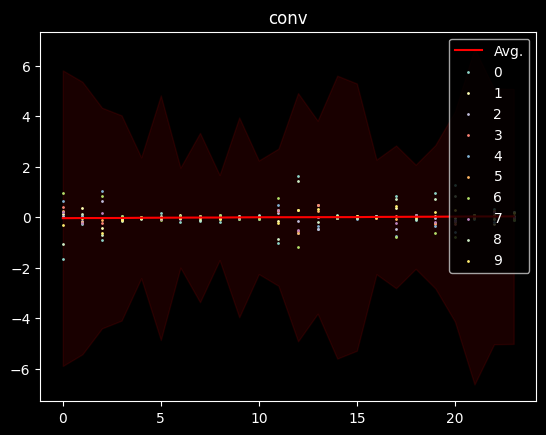

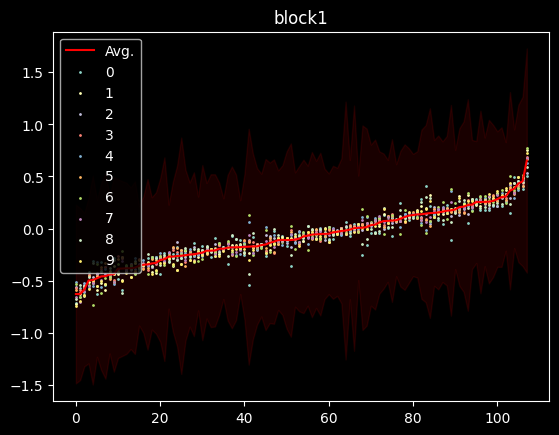

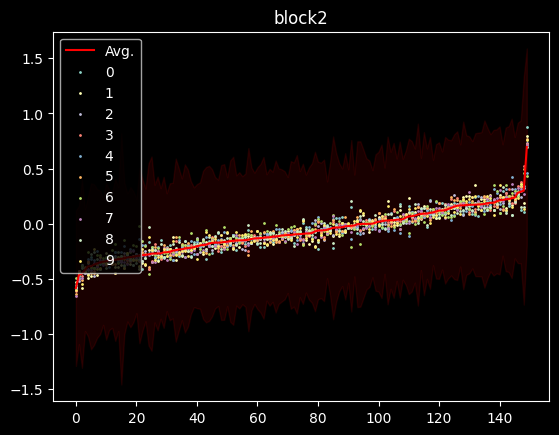

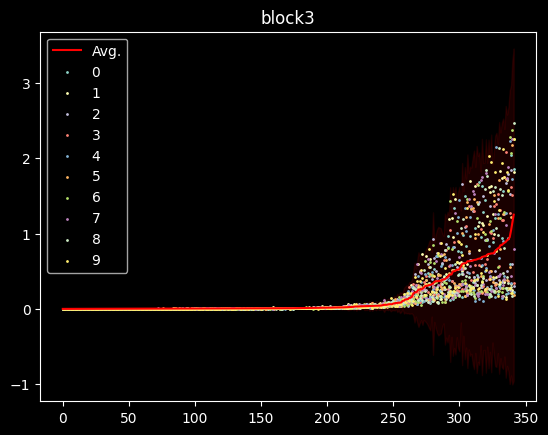

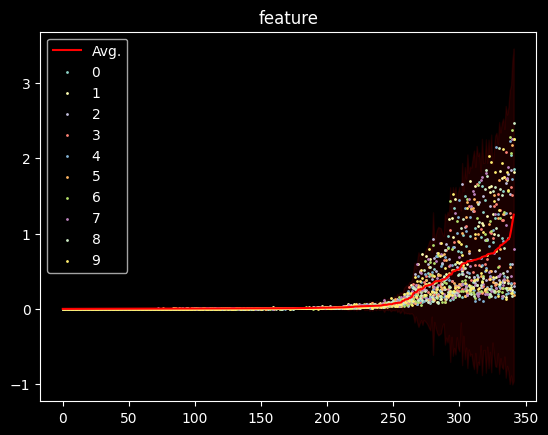

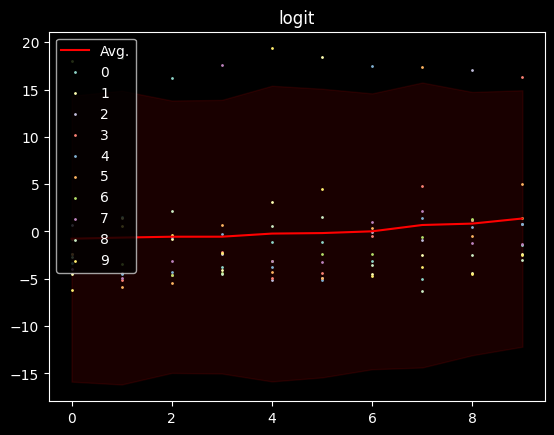

In [7]:
res = [s.compute(i) for i in range(10)]
feats = {v: [] for v in return_nodes.values()}
for f in res:
  for k, v in f.items():
    feats[k].append(v)

avg, std = s.compute(std=True)

indices = {}
for k, v in avg.items():
  indices[k] = v.argsort()

for k, v in feats.items():
  plt.title(k)
  plt.plot(range(len(avg[k])), avg[k][indices[k]], c='red', label='Avg.')
  plt.fill_between(range(len(avg[k])), (avg[k] - 2*std[k])[indices[k]], (avg[k] + 2*std[k])[indices[k]], color='red', alpha=.1)
  for i, y in enumerate(v):
    plt.scatter(range(len(y)), y[indices[k]], s=1, label=f'{i}')
  plt.legend()
  plt.show()